**Introduction**

Forest fires are very dangerous to humans and animals as well

In [3]:
import sqlite3 #importing to use database functions
import pandas as pd #importing to use pandas functions for dataframes
import matplotlib.pyplot as plt #importing to use for plotting graphs
import matplotlib.patches as mp #importing to use as the legend when plotting graphs
import numpy as np #importing to use for numpy arrays 
import folium #used for the maps
import plotly.express as px
from shapely.geometry import Polygon #used for plotting the choropleth
from geojson import Point, Feature, FeatureCollection #used for plotting the choropleth
import statsmodels.formula.api as smf #used for the OLS regression and hypothesis testing
from sklearn import preprocessing #used for the label encoder to convert qualitative to quantitative data
from sklearn.neighbors import KNeighborsClassifier #used for KNN
from sklearn.model_selection import train_test_split #used to split the data into testing and training data for KNN
from sklearn import metrics #used to test the accuracy of the KNN



**Data Collection and Parsing**

I downloaded a microsoft ACCDB and opened up the Fires Spreadsheet. I then converted the spreadsheet to a csv file to be read into python

https://www.fs.usda.gov/rds/archive/catalog/RDS-2013-0009.4

In [4]:
#opening the csv file
data = pd.read_csv("Fires.csv", low_memory= False)
data.head()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,...,0.10,A,40.036944,-121.005833,5,USFS,CA,63.0,63.0,Plumas
1,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,...,0.25,A,38.933056,-120.404444,5,USFS,CA,61.0,61.0,Placer
2,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,...,0.10,A,38.984167,-120.735556,13,STATE OR PRIVATE,CA,17.0,17.0,El Dorado
3,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,...,0.10,A,38.559167,-119.913333,5,USFS,CA,3.0,3.0,Alpine
4,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,...,0.10,A,38.559167,-119.933056,5,USFS,CA,3.0,3.0,Alpine


**Data Management and Tidying**

In [5]:
#renaming this column to get a better understanding
data.rename(columns={'NWCG_REPORTING_UNIT_NAME': 'FOREST_LOC'}, inplace= True)

In [6]:
#Extracting the columns that will be most useful for analyzing the fires.
data = data[['FOREST_LOC', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_DESCR', 'STATE']]
data.head()

,FOREST_LOC,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE
0,Plumas National Forest,2005,2/2/2005,33,1300,9,Miscellaneous,2/2/2005,33.0,1730.0,0.10,A,40.036944,-121.005833,USFS,CA
1,Eldorado National Forest,2004,5/12/2004,133,845,1,Lightning,5/12/2004,133.0,1530.0,0.25,A,38.933056,-120.404444,USFS,CA
2,Eldorado National Forest,2004,5/31/2004,152,1921,5,Debris Burning,5/31/2004,152.0,2024.0,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA
3,Eldorado National Forest,2004,6/28/2004,180,1600,1,Lightning,7/3/2004,185.0,1400.0,0.10,A,38.559167,-119.913333,USFS,CA
4,Eldorado National Forest,2004,6/28/2004,180,1600,1,Lightning,7/3/2004,185.0,1200.0,0.10,A,38.559167,-119.933056,USFS,CA


In [7]:
#counting the total number of fires by state
df6 = data.groupby('STATE').agg({'STATE':['count']})
df6.columns = df6.columns.droplevel(0)
arr = []
for fire in data.iterrows():
    state = fire[1]['STATE']
    arr.append(df6['count'][state])

data['amount'] = np.array(arr)

In [16]:
#plotting a sample of fires corresponding to states on a US map
df7 = data.sample(n=2500)
features = []
for fire in df7.iterrows():
    x = fire[1]['LATITUDE']
    y = fire[1]['LONGITUDE']
    point = Point((x, y)) #create a point object to be used for plotting
    features.append(Feature(geometry=point)) #using the point objects to create a list of geojsons for plotting
feature_collection = FeatureCollection(features)
#specifications
fig = px.choropleth(df7,
    geojson=feature_collection, 
    locations= 'STATE',
    color='amount',
    color_continuous_scale="Reds",
    locationmode= 'USA-states',
    scope="usa",
    range_color = (0, 12000),
    title = 'Amount of Fires in US States From 1992-2015'
)

fig.show()

In [13]:
#creating another map in the US with specific locations of fires
us_fire_map = folium.Map(location=[48, -102], zoom_start=4)


In [14]:
#plotting a random sample of fires and their locations on a US map
df2 = data.sample(n=1000)
for fire in df2.iterrows():
    x = fire[1]['LATITUDE']
    y = fire[1]['LONGITUDE']
    if fire[1]['FIRE_SIZE'] >= 50: 
        color = "pink"
    elif fire[1]['FIRE_SIZE'] >= 10: 
        color = "orange"
    else:
        color = "red"
    folium.Marker(
        location=[x, y],
        popup= fire[1]['STAT_CAUSE_DESCR'],
        icon=folium.Icon(color=color),
    ).add_to(us_fire_map)

us_fire_map

In [9]:
#creating a new column called year in the dataframe
arr = []
for row in data.iterrows():
    arr.append(row[1]['DISCOVERY_DATE'][-4:])

data['year'] = np.array(arr)


In [10]:
#converting the year column to type int
data['year'] = data['year'].astype(int)

In [11]:
#getting the counts of fires for each year
df3 = data.groupby('year').agg({'year':['count']})
df3.columns = df3.columns.droplevel(0)
df3.index = df3.index.astype(str)

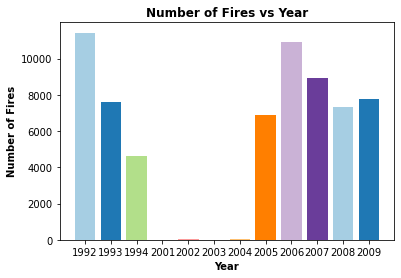

In [12]:
#plotting the counts of fires for each year
fig_num = 0
plt.figure(fig_num)
plt.bar(df3.index, df3['count'], color = plt.cm.Paired(np.arange(10)))
plt.title('Number of Fires vs Year', fontweight = 'bold') #title for plots
plt.xlabel('Year', fontweight = 'bold') #x label for plots
plt.ylabel('Number of Fires' , fontweight = 'bold') #y label for plots
fig_num += 1 #go to the next figure

In [13]:
#getting the counts of fires for each state
df3 = data.groupby('STATE').agg({'STATE':['count']})
df3.columns = df3.columns.droplevel(0)
df3.index = df3.index.astype(str)

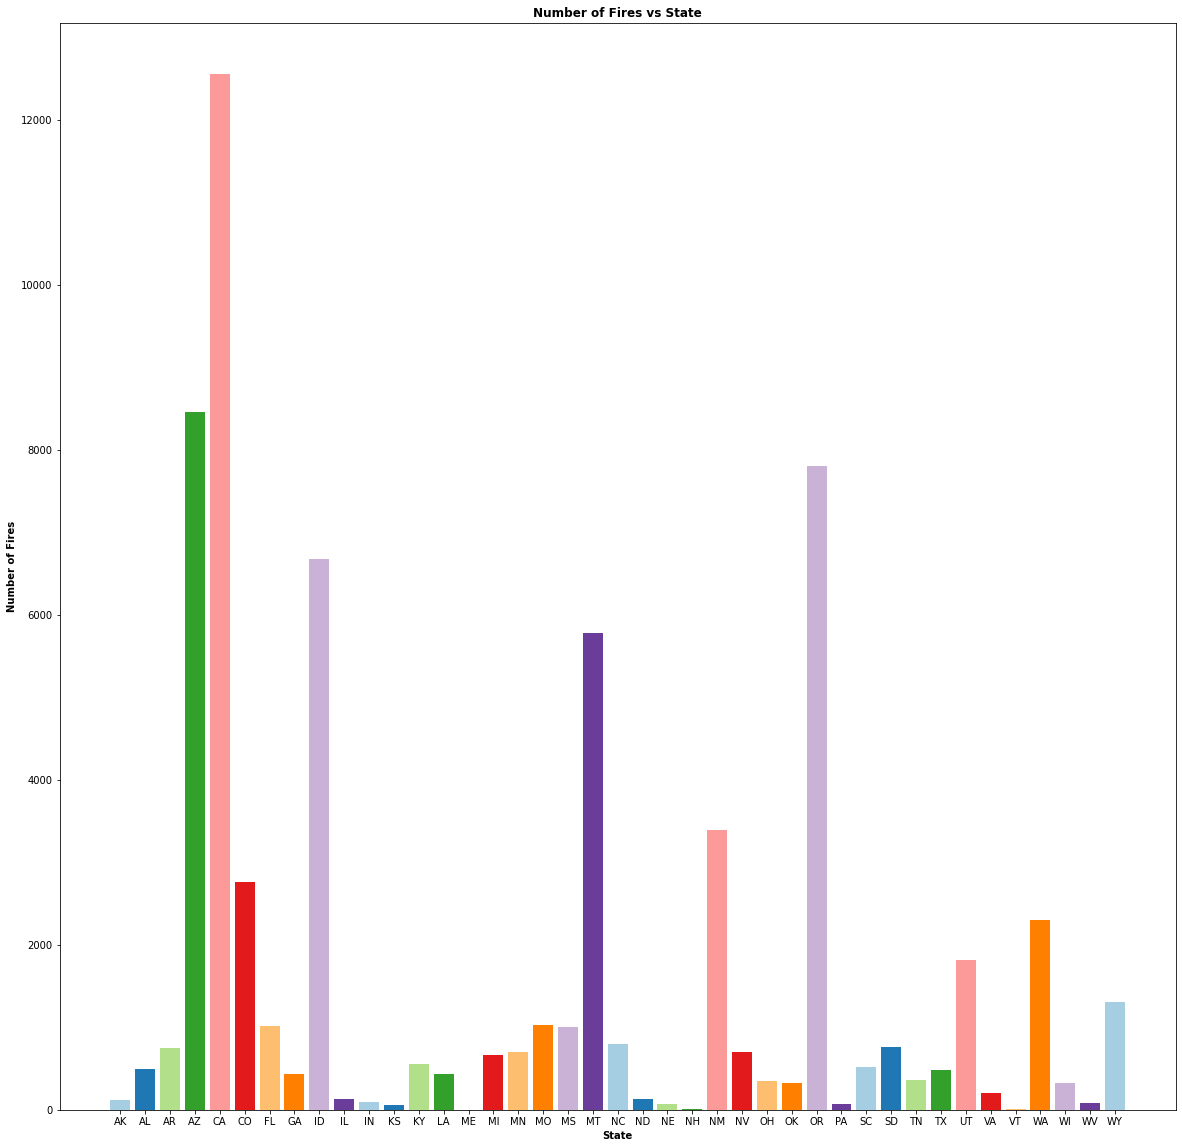

In [46]:
#plotting the counts of fires for each state
plt.figure(fig_num, figsize = (20, 20))
plt.bar(df3.index, df3['count'], color = plt.cm.Paired(np.arange(10)))
plt.title('Number of Fires vs State', fontweight = 'bold') #title for plots
plt.xlabel('State', fontweight = 'bold') #x label for plots
plt.ylabel('Number of Fires' , fontweight = 'bold') #y label for plots
fig_num += 1 #go to the next figure

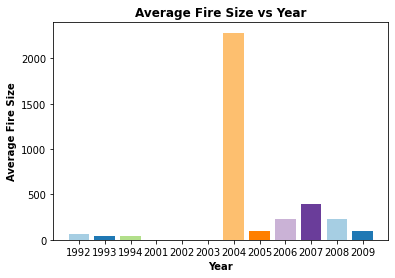

In [15]:
#getting the average fire size by year and plotting it
df5 = data.groupby('year')['FIRE_SIZE'].mean()
df5.index = df5.index.astype(str)
plt.figure(fig_num)
plt.bar(df5.index, df5, color = plt.cm.Paired(np.arange(10)))
plt.title('Average Fire Size vs Year', fontweight = 'bold') #title for plots
plt.xlabel('Year', fontweight = 'bold') #x label for plots
plt.ylabel('Average Fire Size' , fontweight = 'bold') #y label for plots
fig_num += 1 #go to the next figure

In [20]:
#getting the average fire size by state and plotting it
df4 = data.groupby('STATE')['FIRE_SIZE'].mean()

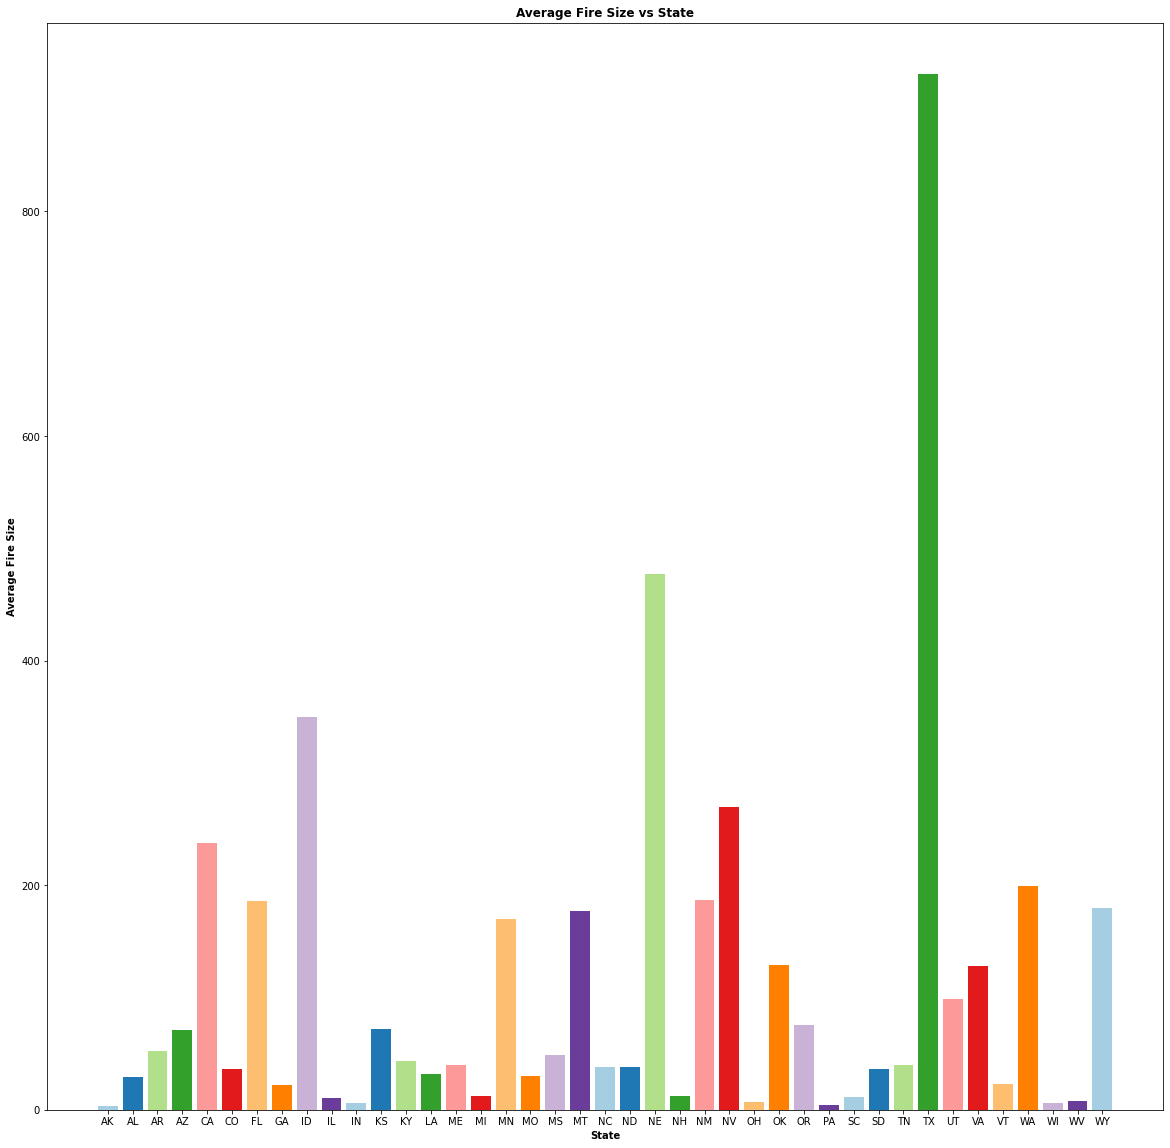

In [17]:
plt.figure(fig_num, figsize = (20, 20))
plt.bar(df4.index, df4, color = plt.cm.Paired(np.arange(10)))
plt.title('Average Fire Size vs State', fontweight = 'bold') #title for plots
plt.xlabel('State', fontweight = 'bold') #x label for plots
plt.ylabel('Average Fire Size' , fontweight = 'bold') #y label for plots
fig_num += 1 #go to the next figure

In [34]:
#getting the counts for each cause of the fires
df8 = data.groupby('STAT_CAUSE_DESCR').agg({'STAT_CAUSE_DESCR': ['count']})
df8.columns = df8.columns.droplevel(0)


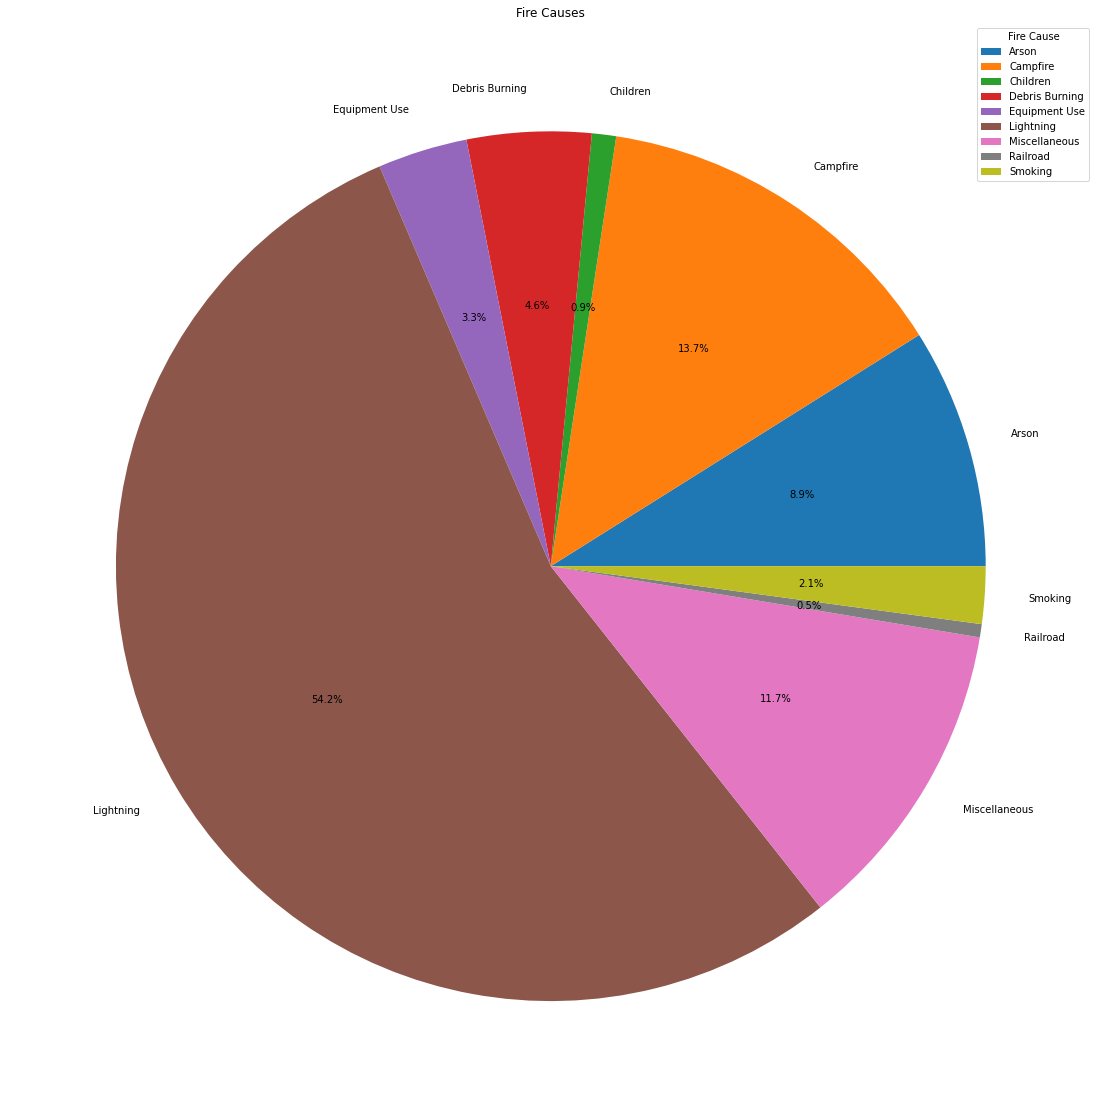

In [35]:
#creating a pie chart to represent the percentages of fire causes
plt.figure(fig_num, figsize = (20, 20))
plt.pie(df8['count'], labels = df8.index, autopct='%1.1f%%')
plt.title("Fire Causes")
plt.legend(title = "Fire Cause")
plt.show()

In [36]:
#getting the counts for the description of fires
df9 = data.groupby('OWNER_DESCR').agg({'OWNER_DESCR': ['count']})
df9.columns = df9.columns.droplevel(0)


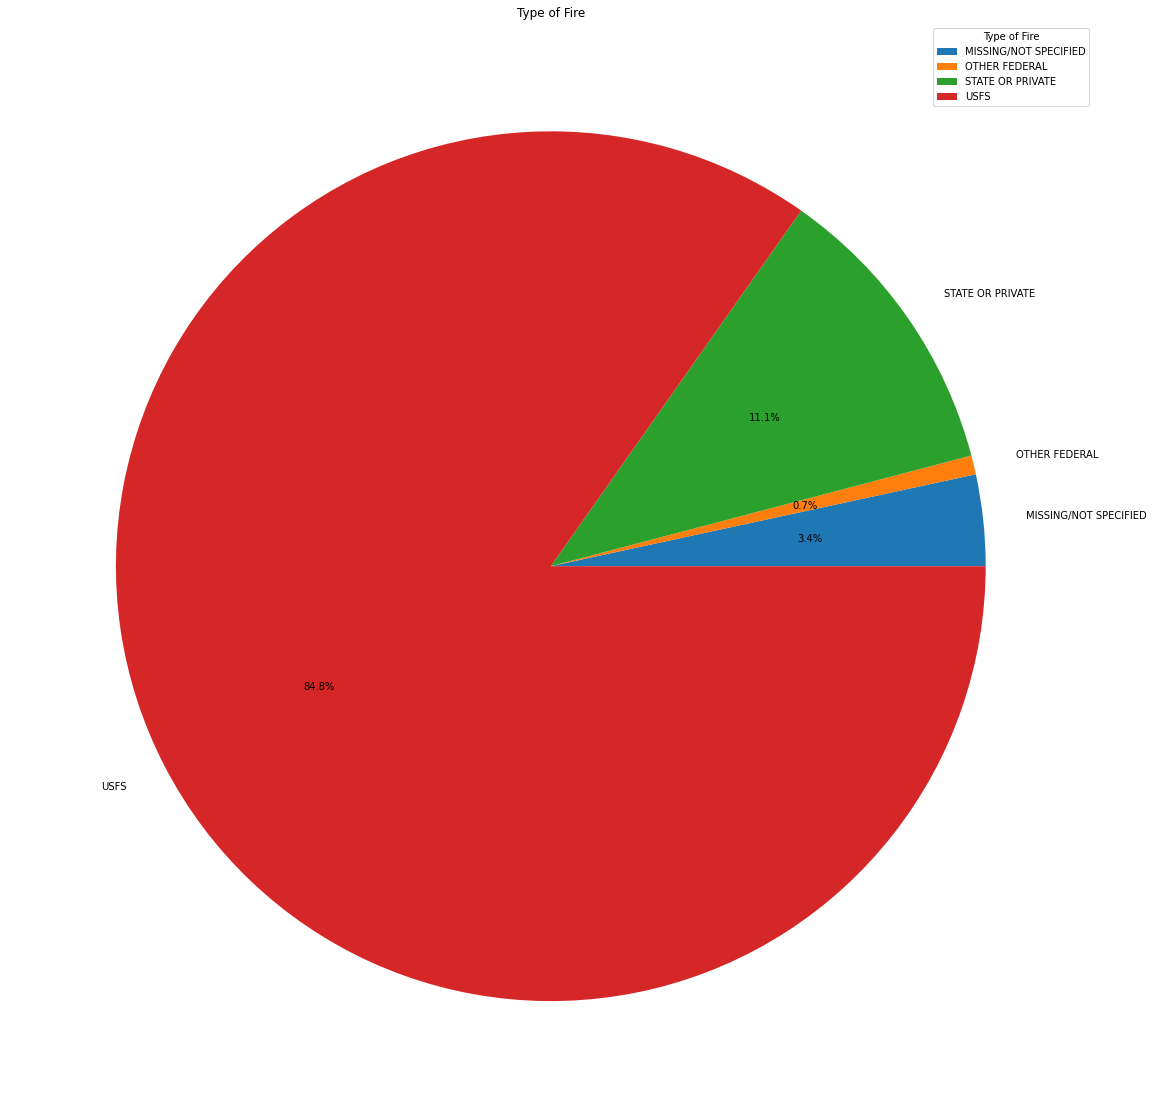

In [37]:
#creating a pie chart for the counts for the descriptions of the fires
plt.figure(fig_num, figsize = (20, 20))
plt.pie(df9['count'], labels = df9.index, autopct='%1.1f%%')
plt.title("Type of Fire")
plt.legend(title = "Type of Fire")
plt.show()
fig_num += 1

In [39]:
#getting the counts of fires based on the day they were discovered
df10 = data.groupby('DISCOVERY_DOY').agg({'DISCOVERY_DOY': ['count']})
df10.columns = df10.columns.droplevel(0)

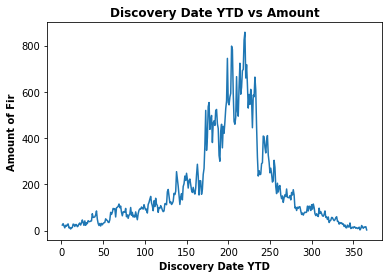

In [47]:
#plotting the counts of fires based on the day they were discovered
plt.figure(fig_num)
plt.plot(df10.index, df10['count'])
plt.title('Discovery Date YTD vs Amount' , fontweight = 'bold') #name the graph with a title
plt.xlabel('Discovery Date YTD', fontweight = 'bold') #name the x labels
plt.ylabel('Amount of Fire' , fontweight = 'bold') #name the y labels
plt.show()
fig_num += 1

In [60]:
#getting the counts of fires based on the time they were discovered
df11= data.groupby('DISCOVERY_TIME').agg({'DISCOVERY_TIME': ['count']})
df11.columns = df11.columns.droplevel(0)

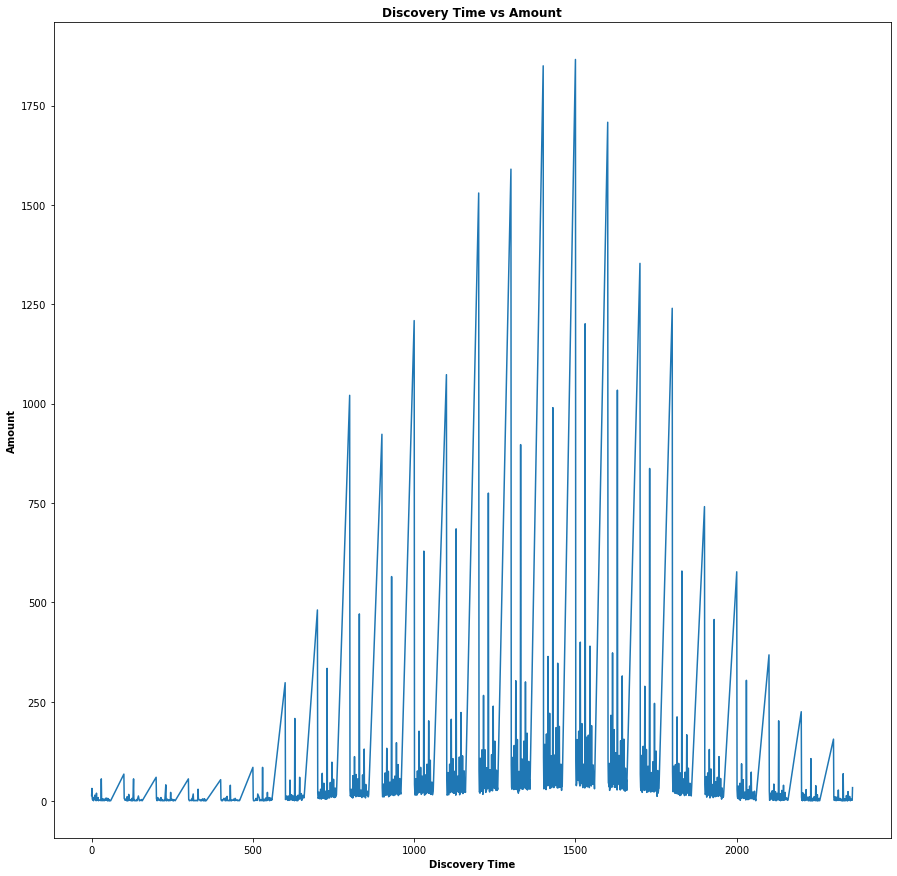

In [62]:
#plotting the counts of fires based on the time they were discovered
plt.figure(fig_num, figsize=(15,15))
plt.plot(df11.index, df11['count'])
plt.title('Discovery Time vs Amount' , fontweight = 'bold') #name the graph with a title
plt.xlabel('Discovery Time', fontweight = 'bold') #name the x labels
plt.ylabel('Amount' , fontweight = 'bold') #name the y labels
plt.show()
fig_num += 1

In [ ]:
#Hypothesis Testing Including Feature Engineering

In [98]:
#conducting a hypothesis test with an OLS regression to determine the effect various factors had on the amount of fires
formula = 'amount ~ FOREST_LOC + FIRE_YEAR + DISCOVERY_DOY + STAT_CAUSE_CODE + STAT_CAUSE_DESCR + LATITUDE + LONGITUDE + OWNER_DESCR'
lm = smf.ols(formula, data).fit()
lm.summary()

=====================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    -1.588e+04    684.040    -23.212      0.000   -1.72e+04   -1.45e+04
FOREST_LOC[T.Angeles National Forest]                                         -519.7479    201.893     -2.574      0.010    -915.458    -124.038
FOREST_LOC[T.Apache-Sitgreaves National Forest]                              -1953.3824    174.558    -11.190      0.000   -2295.515   -1611.250
FOREST_LOC[T.Arapaho & Roosevelt National Forests/Pawnee National Grassland] -6086.1816    155.284    -39.194      0.000   -6390.538   -5781.825
FOREST_LOC[T.Ashley National Forest]                                         -8542.6932    174.592    -48.929      0.000   -8884.894   -8200.492
FOREST_LOC[T.Beaverhead/Deerlodge National Forest]                           -5408.9775    177.807    -30.420      0.000   -5757.479   -5060.476
FOREST_LOC[T.Bighorn National Forest]                                        -8054.1387    165.818    -48.572      0.000   -8379.142   -7729.136
FOREST_LOC[T.Bitterroot National Forest]                                     -5669.9490    181.070    -31.313      0.000   -6024.847   -5315.051
FOREST_LOC[T.Black Hills National Forest]                                    -7400.1805    146.898    -50.376      0.000   -7688.100   -7112.261
FOREST_LOC[T.Boise National Forest]                                          -5508.9553    185.432    -29.709      0.000   -5872.401   -5145.509
FOREST_LOC[T.Bridger-Teton National Forest]                                  -9154.4760    169.782    -53.919      0.000   -9487.248   -8821.704
FOREST_LOC[T.Caribou-Targhee National Forest]                                -4664.6533    174.429    -26.742      0.000   -5006.534   -4322.772
FOREST_LOC[T.Carson National Forest]                                         -5755.3500    162.371    -35.446      0.000   -6073.598   -5437.102
FOREST_LOC[T.Chattahoochee-Oconee National Forest]                           -1380.6783    117.849    -11.716      0.000   -1611.662   -1149.695
FOREST_LOC[T.Chequamegon-Nicolet National Forest]                            -3216.9546    119.590    -26.900      0.000   -3451.351   -2982.559
FOREST_LOC[T.Cherokee National Forest]                                       -1276.4456    116.375    -10.968      0.000   -1504.541   -1048.350
FOREST_LOC[T.Chippewa National Forest]                                       -4351.8453    130.939    -33.236      0.000   -4608.485   -4095.205
FOREST_LOC[T.Chugach National Forest]                                        -2.295e+04    351.681    -65.270      0.000   -2.36e+04   -2.23e+04
FOREST_LOC[T.Cibola National Forest]                                         -6227.4738    162.879    -38.234      0.000   -6546.717   -5908.231
FOREST_LOC[T.Cleveland National Forest]                                       -118.3479    201.278     -0.588      0.557    -512.854     276.158
FOREST_LOC[T.Coconino National Forest]                                       -2448.1459    177.378    -13.802      0.000   -2795.806   -2100.486
FOREST_LOC[T.Columbia River Gorge National Scenic Area]                      -8527.1383    219.566    -38.836      0.000   -8957.487   -8096.790
FOREST_LOC[T.Colville National Forest]                                       -1.051e+04    199.677    -52.620      0.000   -1.09e+04   -1.01e+04
FOREST_LOC[T.Coronado National Forest]                                       -2115.4311    182.647    -11.582      0.000   -2473.420   -1757.442
FOREST_LOC[T.Custer Gallatin National Forest]                                -4228.9157    161.6

In [97]:
#conducting a hypothesis test by creating an OLS regression to determine the effect that various factors had on fire size
formula = 'FIRE_SIZE ~ FOREST_LOC + FIRE_YEAR + DISCOVERY_DOY + STAT_CAUSE_CODE + STAT_CAUSE_DESCR + LATITUDE + LONGITUDE + OWNER_DESCR + STATE'
lm2 = smf.ols(formula, data).fit()
lm2.summary()

T.Grand Mesa/Uncompahgre/Gunnison National Forest]                 -637.5373   1074.025     -0.594      0.553   -2742.626    1467.551
FOREST_LOC[T.Green Mountain National Forest]                                  -806.0694    560.860     -1.437      0.151   -1905.355     293.216
FOREST_LOC[T.Helena National Forest]                                          -959.5149    829.481     -1.157      0.247   -2585.299     666.269
FOREST_LOC[T.Hiawatha National Forest]                                        -427.0363   1546.111     -0.276      0.782   -3457.415    2603.342
FOREST_LOC[T.Hoosier National Forest]                                         -625.5211    266.540     -2.347      0.019   -1147.940    -103.103
FOREST_LOC[T.Humboldt-Toiyabe National Forest]                                1305.5197    932.000      1.401      0.161    -521.201    3132.240
FOREST_LOC[T.Huron-Manistee National Forest]                                  -299.9468   1513.883     -0.198      0.843   -3267.158    2667.265
FOREST_LOC[T.Idaho Panhandle National Forest]                                -1171.7951    798.222     -1.468      0.142   -2736.311     392.721
FOREST_LOC[T.Inyo National Forest]                                            1346.2323    934.479      1.441      0.150    -485.348    3177.812
FOREST_LOC[T.Kaibab National Forest]                                          1868.8239   3200.109      0.584      0.559   -4403.390    8141.037
FOREST_LOC[T.Kisatchie National Forest]                                       -499.3891    220.918     -2.261      0.024    -932.388     -66.390
FOREST_LOC[T.Klamath National Forest]                                         1304.1961    928.151      1.405      0.160    -514.981    3123.373
FOREST_LOC[T.Kootenai National Forest]                                       -1070.7318    821.099     -1.304      0.192   -2680.086     538.622
FOREST_LOC[T.Lake Tahoe Basin Management Unit]                                1274.4202    940.341      1.355      0.175    -568.648    3117.489
FOREST_LOC[T.Land Between the Lakes National Recreation Area]                 -588.0633   1509.808     -0.389      0.697   -3547.287    2371.160
FOREST_LOC[T.Lassen National Forest]                                          1312.5988    931.467      1.409      0.159    -513.077    3138.275
FOREST_LOC[T.Lewis & Clark National Forest]                                   -465.1567    846.497     -0.550      0.583   -2124.292    1193.978
FOREST_LOC[T.Lincoln National Forest]                                          -74.2154   2883.085     -0.026      0.979   -5725.062    5576.631
FOREST_LOC[T.Lolo National Forest]                                            -987.9611    814.056     -1.214      0.225   -2583.511     607.589
FOREST_LOC[T.Los Padres National Forest]                                      4129.0922    949.828      4.347      0.000    2267.428    5990.756
FOREST_LOC[T.Malheur National Forest]                                         1289.4496    816.650      1.579      0.114    -311.184    2890.084
FOREST_LOC[T.Manti-Lasal National Forest]                                     -596.3432    900.267     -0.662      0.508   -2360.866    1168.180
FOREST_LOC[T.Mark Twain National Forest]                                      -592.9395    186.322     -3.182      0.001    -958.131    -227.748
FOREST_LOC[T.Medicine Bow National Forest]                                    -838.2850    865.267     -0.969      0.333   -2534.209     857.639
FOREST_LOC[T.Mendocino National Forest]                                       1610.7315    949.497      1.696      0.090    -250.282    3471.745
FOREST_LOC[T.Midewin National Tall Grass Prairie]                             -544.6325    698.718     -0.779      0.436   -1914.120     824.855
FOREST_LOC[T.Modoc National Forest]                                           1178.7398    927.571      1.271      0.204    -639.299    2996.778
FOREST_LOC[T.Monongahela National Forest]                                     -642.8404   1233.1

In [ ]:
#Machine Learning with K-th Nearest Neighbor

In [161]:
#converting the data from qualitative to quantitative to be in a proper format for KNN to predict the amount of fires
le = preprocessing.LabelEncoder()
FOREST_LOC_encoded=le.fit_transform(data['FOREST_LOC'])
DISCOVERY_DOY_encoded=le.fit_transform(data['DISCOVERY_DOY'])
STAT_CAUSE_DESCR_encoded = le.fit_transform(data['STAT_CAUSE_DESCR'])
OWNER_DESCR_encoded = le.fit_transform(data['OWNER_DESCR'])
STATE_encoded = le.fit_transform(data['STATE'])
LAT_encoded = le.fit_transform(data['LATITUDE'])
LONG_encoded = le.fit_transform(data['LONGITUDE'])
label = le.fit_transform(data['amount'])
features = list(zip(FOREST_LOC_encoded, DISCOVERY_DOY_encoded, STAT_CAUSE_DESCR_encoded, OWNER_DESCR_encoded, LAT_encoded, LONG_encoded, STATE_encoded))

In [162]:
#splitting the training and test data with 30% of the data being used for the test data
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3)

In [163]:
#creating a kth nearest neighbors object with k = 10
knn = KNeighborsClassifier(n_neighbors=10)

In [164]:
#fitting the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [166]:
#having the model make predictions based on the KNN
y_pred = knn.predict(X_test)

In [167]:
#comparing the predictions of fire amounts to the actual test data and determining the accuracy
metrics.accuracy_score(y_test, y_pred)

0.9924724073037994

In [175]:
#converting the data from qualitative to quantitative to be in a proper format for KNN to predict the size of fires
label2 = le.fit_transform(data['FIRE_SIZE'])
features2 = list(zip(FOREST_LOC_encoded, DISCOVERY_DOY_encoded, STAT_CAUSE_DESCR_encoded, OWNER_DESCR_encoded, LAT_encoded, LONG_encoded, STATE_encoded))

In [176]:
#splitting the training and test data with 30% of the data being used for the test data
X_train, X_test, y_train, y_test = train_test_split(features2, label2, test_size=0.3)

In [177]:
#creating a kth nearest neighbors object with k = 10
knn = KNeighborsClassifier(n_neighbors=10)

In [178]:
#fitting the training data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [179]:
#having the model make predictions based on the KNN
y_pred = knn.predict(X_test)

In [180]:
#comparing the predictions of fire size to the actual test data and determining the accuracy
metrics.accuracy_score(y_test, y_pred)

0.49921163725141143